In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import MTLR
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
# Dataset

path = "E:/Research/Ovarian Cancer/Articles/Orginal/"
data = pd.read_excel(path+"data_ready.xlsx")

df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
data['YearSurvive'].value_counts()

1     474
6     427
7     383
9     259
2     249
8     245
3     217
4     166
10    132
5     123
Name: YearSurvive, dtype: int64

In [5]:
# Feature transformers

cols_standardize = ['Age']
cols_onehotencoded = ['Grading', 'Histology', 'Type']

standardize = [([col], StandardScaler()) for col in cols_standardize]
onehot_encoded = [([col], OneHotEncoder(handle_unknown='ignore')) for col in cols_onehotencoded]

#encoded = [([col], LabelEncoder()) for col in cols_labelencoded]
#leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + onehot_encoded)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
# label transforms

num_durations = 10
labtrans = MTLR.label_transform(num_durations)
get_target = lambda df: (df['YearSurvive'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [8]:
type(labtrans)


pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [9]:
# Neural Net

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [10]:
# model

model = MTLR(net, tt.optim.Adam, duration_index=labtrans.cuts)

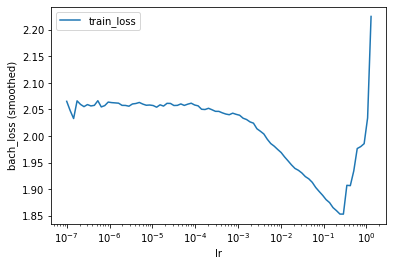

In [11]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=6)
_ = lr_finder.plot()

In [12]:
lr_finder.get_best_lr()

0.029150530628251937

In [13]:
model.optimizer.set_lr(0.01)

In [14]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.8333,	val_loss: 1.7838
1:	[0s / 0s],		train_loss: 1.6630,	val_loss: 1.6961
2:	[0s / 0s],		train_loss: 1.6107,	val_loss: 1.6718
3:	[0s / 0s],		train_loss: 1.5773,	val_loss: 1.6226
4:	[0s / 0s],		train_loss: 1.5403,	val_loss: 1.6006
5:	[0s / 0s],		train_loss: 1.5236,	val_loss: 1.5765
6:	[0s / 0s],		train_loss: 1.4972,	val_loss: 1.5711
7:	[0s / 0s],		train_loss: 1.4801,	val_loss: 1.5578
8:	[0s / 0s],		train_loss: 1.4797,	val_loss: 1.5605
9:	[0s / 0s],		train_loss: 1.4571,	val_loss: 1.5500
10:	[0s / 0s],		train_loss: 1.4643,	val_loss: 1.5568
11:	[0s / 0s],		train_loss: 1.4569,	val_loss: 1.5407
12:	[0s / 0s],		train_loss: 1.4548,	val_loss: 1.5497
13:	[0s / 0s],		train_loss: 1.4390,	val_loss: 1.5503
14:	[0s / 0s],		train_loss: 1.4350,	val_loss: 1.5440
15:	[0s / 0s],		train_loss: 1.4396,	val_loss: 1.5450
16:	[0s / 0s],		train_loss: 1.4402,	val_loss: 1.5364
17:	[0s / 0s],		train_loss: 1.4414,	val_loss: 1.5274
18:	[0s / 0s],		train_loss: 1.4354,	val_loss: 1.5497
19:

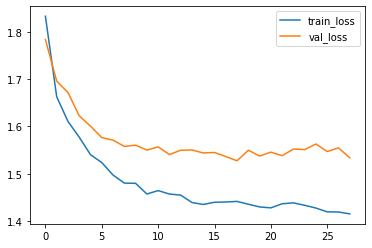

In [15]:
_ = log.plot()

In [16]:
surv = model.predict_surv_df(x_test)

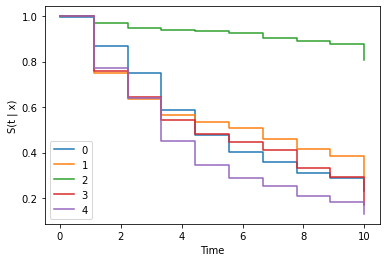

In [17]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [18]:
surv = model.interpolate(10).predict_surv_df(x_test)

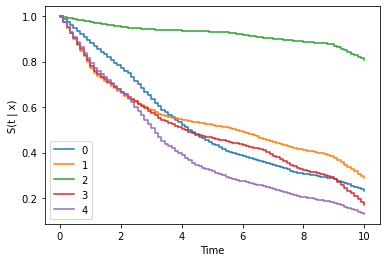

In [19]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
# Evaluation

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [21]:
ev.concordance_td('antolini')

0.6761258666242873

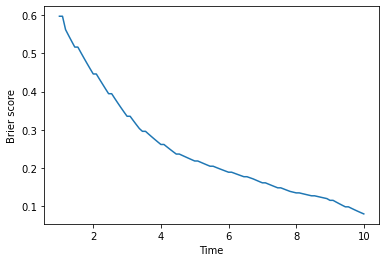

In [22]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

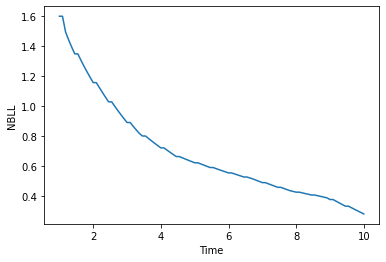

In [23]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [24]:
ev.integrated_brier_score(time_grid) 

0.24480555737564247

In [25]:
ev.integrated_nbll(time_grid) 

0.6859983137699385